In [9]:
print("Loading modules...")
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import skimage
import pixstem.api as ps
import multiprocessing
import hyperspy.api as hs
import ctypes
import csv
print("Modules loaded.")
import os
import tkinter as tk
from tkinter import *
from tkinter import ttk
from tkinter.filedialog import askopenfilename
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.figure import Figure

file = None
distances = None

Loading modules...
Modules loaded.


In [10]:
def loadFile(fileName='newfile.blo'):
    global file
    check= os.path.isfile(fileName)
    if check is True:
        print("Loading file...")
        file = hs.load(fileName)
        print("File loaded.")
    else:
        print("File not found")
    #menu()

def distance(x1, y1, x2, y2):
    return np.sqrt(pow(x1 - x2, 2) + pow(y1 - y2, 2))

def pos_dist(x1, y1, x2, y2):# remove this section since the distance will never be negative 
    if (x2 > x1 and y2 > y1):
        return np.sqrt(pow(x1 - x2, 2) + pow(y1 - y2, 2))
    else:
        return -1.0

def findCenter(im, peak):
    center = (0,0)
    maximum = 0
    for (x,y) in np.ndenumerate(peak):
        for (a, b) in y:
            if (int(a) < len(im) and int(b) < len(im) and im[int(a)][int(b)] > maximum):
                maximum = im[int(a)][int(b)]
                center = (b, a)
    return center

def multiprocessing_func(i, j, rnd):
    s = ps.PixelatedSTEM(hs.signals.Signal2D(file.inav[i, j]))
    imarray = np.array(s)
    s = s.rotate_diffraction(0,show_progressbar=False)
    ############################################################################################################################
    st = s.template_match_disk(disk_r=5, lazy_result=False, show_progressbar=False)
    peak_array = st.find_peaks(lazy_result=False, show_progressbar=False)
    peak_array_com = s.peak_position_refinement_com(peak_array, lazy_result=False, show_progressbar=False)
    s_rem = s.subtract_diffraction_background(lazy_result=False, show_progressbar=False)
    peak_array_rem_com = s_rem.peak_position_refinement_com(peak_array, lazy_result=False, show_progressbar=False)
    ############################################################################################################################
    center = findCenter(imarray, peak_array_rem_com)

    # finds the specific spot and adding that distance to the array
    posDistance = 0
        
    for (x,y) in np.ndenumerate(peak_array_rem_com):
        prev = (0, 0)
        for (a, b) in y:
            if abs(center[0] - b) < 1E-5 and abs(center[1] - a) < 1E-5:
                posDistance = distance(center[0], center[1], prev[1], prev[0])
                break
            prev = (a, b)
    distances[j][i] = round(posDistance, rnd)

In [11]:
def analysis(ROW = 10, COL = 10, rnd = 2):
    global distances#Don't use global vareiables pass it in as an argument
    print("Starting analysis...")
    
    shared_array_base = multiprocessing.Array(ctypes.c_double, ROW*COL)#empty<==== ?
    distances = np.ctypeslib.as_array(shared_array_base.get_obj())
    distances = distances.reshape(COL, ROW)

    for i in range(ROW):
        print(i)
        processes = []
        #try using multiprocessing Pool by MAH 
        for j in range(COL):
            p = multiprocessing.Process(target=multiprocessing_func, args=(i, j, rnd,))
            processes.append(p)
            p.start()

        for process in processes:
            process.join()  
    print("Analysis complete.")
    #menu()

def toCSV(filename = "outputDistances.csv"):
    file = open(filename, "w")
    writer = csv.writer(file)
    for i in distances:
        writer.writerow(i)
    file.close()

def barChart(INTERVAL = 0.01,save = False):
    global distances
    dist = distances.flatten()
    x_pos = np.arange(np.min(dist), np.max(dist), INTERVAL) # this 0.01 is the distance between each x-axis label. So for example it goes 1.0, 1.01, 1.02, 1.03...
    x_pos = [round(num, 2) for num in x_pos]
    y_pos = np.arange(len(x_pos))
    ################################################################################################################################
    from collections import Counter
    counter = Counter(dist)
    counts = []
    for i in x_pos:
            counts.append(counter[i]) if i in counter.keys() else counts.append(0)
    ################################################################################################################################
    plt.xticks(y_pos, x_pos, fontsize = 5)
    plt.xlabel('The Distance From The Center Peak', fontsize = 5)
    plt.ylabel('Counts', fontsize = 5)
    plt.title('Number Of Counts Vs The Distance From The Center Peak', fontsize = 5)
    plt.bar(y_pos, counts, align='center', alpha=0.95) # creates the bar plot

    ax = plt.gca()
    plt.setp(ax.get_xticklabels(), rotation=90)
    ax.tick_params(axis='x', which='major', labelsize=5)
    ax.tick_params(axis='y', which='major', labelsize=5)

    [l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % 60 != 0] 
    # The '2' is the every nth number of labels its shows on the x-axis. So rn is shows every 2nd label. 

    plt.gcf().subplots_adjust(bottom = 0.23)
    plt.rcParams["figure.dpi"] = 500
    if(save):
        plt.savefig("300x500BarChart.png")
    figure = Figure(figsize=(15,15),dpi = 500)
    a = figure.add_subplot(111)
    a.bar(y_pos,counts)
    return figure
def heatMap():
    global distances
    dist = np.fliplr(distances)
    med = np.median(dist)
    for r in range(len(dist)):
        for c in range(len(dist[r])):
            if dist[r][c] > 25:
                dist[r][c] = med
    # Create data
    
    df = pd.DataFrame(dist, columns=np.arange(len(dist[0])), index=np.arange(len(dist)))
    
    figure = Figure(figsize=(6, 6))
    ax = figure.subplots()
    sns.heatmap(df,ax=ax)
    return figure
    

In [12]:
def menu():
    print("-" * 50)
    print((" " * 23) + "Menu" + (" " * 23))
    print("-" * 50)
    print("1 - Load File")
    print("2 - Start Analysis")
    print("3 - Creation of a Bar Chart")
    print("4 - Creation of a Heat Map")
    print("5 - Creation of a csv file")
    print("q - Quit Program")
    print("-" * 50)
    inpt = input("Please choose an option: ")
    while inpt != "q":
        if inpt == "1":
            fileName = input("Please enter the file name with the .blo extension: ")
            loadFile(fileName)
        elif inpt == "2":
            row, col, rnd = input("Please enter the number of rows and columns you would like to analyze,specifiying the number of significant figures, seperated by a space. (Ex. 5 5 1):").split()
            analysis(int(row), int(col), int(rnd))
        elif inpt == "3":
            INTERVAL = input("Please enter the x-axis interval: ") 
            # this 0.01 is the distance between each x-axis label. So for example it goes 1.0, 1.01, 1.02 1.03...
            barChart(float(INTERVAL))
        elif inpt == "4":
            heatMap()
        elif inpt == "5":
            filename = input("Please enter the filename with the .csv extension: ")
            toCSV(filename)
        elif inpt == "q":
            break
        else:
            inpt = input("Please enter a valid number or q to quit: ")

In [13]:

import os
def loadFile(fileName='newfile.blo'):
    global file
    try:
        print('Loading file...')
        file = hs.load(fileName)
    except:
        print('Error loading file')
        return
    print('File loaded')
    #menu()


In [14]:
def openFile():
    name = askopenfilename(initialdir=os.getcwd(),
                           filetypes =(("blo file", "*.blo"),),
                           title = "Choose a file."
                           )
    
    loadFile(name)

In [15]:
def processEntry(entrys):
    try:
        entrysValues = [int(entry.get()) for entry in entrys]
        
        analysis(entrysValues[0],entrysValues[1],entrysValues[2])
    except:
        print(f'Invalid entry: {[entry.get() for entry in entrys]}')
        return
def openChartWindow():
    barChartWindow = tk.Toplevel(root)
    barChartWindow.geometry('1280x720')
    try:
        figure = barChart()
        chart_type = FigureCanvasTkAgg(figure, barChartWindow)
        chart_type.draw()
        chart_type.get_tk_widget().pack()
    except:
        print('err')
        return
def openHeatMapWindow():
    heatMapWindow = tk.Toplevel(root)
    heatMapWindow.geometry('1280x720')
    try:
        figure = heatMap()
        chart_type = FigureCanvasTkAgg(figure, heatMapWindow)
        chart_type.draw()
        chart_type.get_tk_widget().pack()
    except:
        print('err')
        return

    
def openAnalysisWindow():
    analysisWindow = tk.Toplevel(root)
    analysisWindow.geometry('500x500')
    labels = [Label(analysisWindow,text = 'Columns:'),Label(analysisWindow,text = 'Rows:'),Label(analysisWindow,text = 'Sig figs:')]
    entrys = [Entry(analysisWindow) for i in range(len(labels))]
    
    for i in range(len(labels)):
        labels[i].pack()
        entrys[i].pack()
        
    submitBtn = Button(analysisWindow,text = 'Submit', command = lambda:processEntry(entrys))
    submitBtn.pack()

Loading file...
File loaded
Starting analysis...
0
1
2
3
4
5
6
7
8
9
Analysis complete.


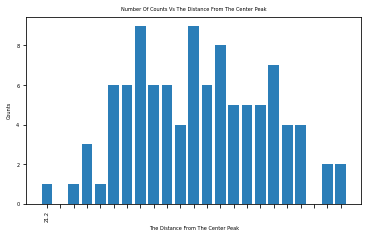

In [17]:
root = Tk()
root.geometry("500x500")
analysisBtn = Button(root,text = 'Analysis',command = openAnalysisWindow)
analysisBtn.pack()
barChartBtn = Button(root,text = 'Bar Chart',command = openChartWindow)
barChartBtn.pack()
heatMapBtn =  Button(root,text = 'Heat Map',command = openHeatMapWindow)
heatMapBtn.pack()
csvBtn = Button(root,text = 'To CSV', command = toCSV)
csvBtn.pack()
guiMenu = Menu(root)
root.config(menu=guiMenu)

fileMenu = Menu(guiMenu)

fileMenu.add_command(label = 'Open', command = openFile)
fileMenu.add_command(label = 'Exit', command = lambda:exit())

guiMenu.add_cascade(label = 'File', menu = fileMenu)

root.mainloop()